<a href="https://colab.research.google.com/github/M4rck0/Aprendizaje_Automatico/blob/main/Tarea_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit

In [13]:
# Entrenar y evaluar el modelo por cluser
def entrenar_xgboost_cluster(df_cluster, cluster_id):
    # Definición variables
    X = df_cluster.drop(columns=['medv', 'cluster'])
    y = df_cluster["medv"]

    # Train / Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelo XGBoost
    modelo = XGBRegressor(
        n_estimators=500, # Número de árboles
        learning_rate=0.05, # Tasa de aprendizaje
        max_depth=4, # Profundidad
        subsample=0.8, # Filas
        colsample_bytree=0.8, # Filas
        random_state=42, # Fijar semilla
        objective="reg:squarederror", #MSE
        n_jobs=-1 # Núcleos - 1
        )

    # Espacio de búsqueda
    parametros = {
      "n_estimators": [400, 700],
      "max_depth": [3, 5],
      }

    # ShuffleSplit
    shufflesplit = ShuffleSplit(n_splits = 50, test_size = 0.2, random_state = 42)

    # GridSearchCV
    gscv = GridSearchCV(
        estimator = modelo,
        param_grid = parametros,
        scoring = "neg_mean_absolute_error",
        cv = shufflesplit,
        n_jobs = -1,
        refit = True,
        verbose = 0,
        return_train_score = True)

    # Ajuste
    gscv.fit(X_train, y_train)

    print(f"[Cluster {cluster_id}] Mejores parametros: {gscv.best_params_}")

    mejor_modelo = gscv.best_estimator_

    # Predicción
    y_predic = mejor_modelo.predict(X_test)

    # Evaluación
    mae = mean_absolute_error(y_test, y_predic)
    rmse = np.sqrt(mean_squared_error(y_test, y_predic))
    r2 = r2_score(y_test, y_predic)

    print(f"MAE = {mae}\nRMSE = {rmse}\nR2 = {r2}")

    # Gráfico real vs predicho
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_predic, alpha=0.7, color="teal")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.xlabel("Valores reales")
    plt.ylabel("Valores predichos")
    plt.title(f"Cluster {cluster_id}: Comparación entre reales y predichos")
    plt.savefig(f"cluster_{cluster_id}_valores_reales_predichos.png")
    plt.show()

    return {"Cluster": cluster_id, "MAE": mae, "RMSE": rmse, "R2": r2}

In [14]:
# Leer datos
df = pd.read_csv("/content/boston.csv")
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [15]:
# Variables
variables = df[['rm', 'lstat']]

# Estandarización
escalar = StandardScaler()
vars_escaladas = escalar.fit_transform(variables)

In [16]:
# Seleccionar número óptimo de clusters con BIC
n_componentes = np.arange(1, 10)
modelos = [GaussianMixture(n, covariance_type = 'full', random_state = 42).fit(vars_escaladas)
           for n in n_componentes]

bics = [modelo.bic(vars_escaladas) for modelo in modelos]

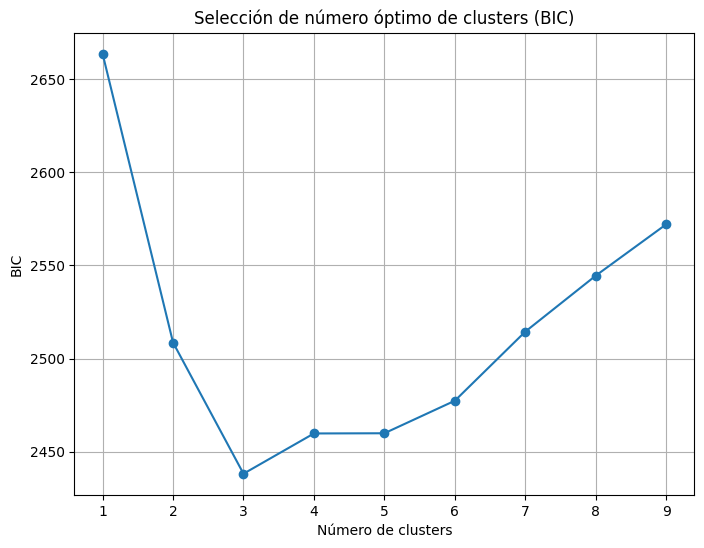

In [17]:
# Graficar BIC vs número de clusters
plt.figure(figsize = (8,6))
plt.plot(n_componentes, bics, marker = 'o')
plt.title("Selección de número óptimo de clusters (BIC)")
plt.xlabel("Número de clusters")
plt.ylabel("BIC")
plt.grid(True)
plt.savefig("grafico_bic.png")
plt.show()

In [18]:
# Determinar k óptimo
k_optimo = n_componentes[np.argmin(bics)]
print(f"Número óptimo de clusters con BIC: {k_optimo}")

Número óptimo de clusters con BIC: 3


In [19]:
# Ajustar modelo GMM con k óptimo
gmm = GaussianMixture(n_components = k_optimo, random_state = 42)
gmm.fit(vars_escaladas)
df['cluster'] = gmm.predict(vars_escaladas)

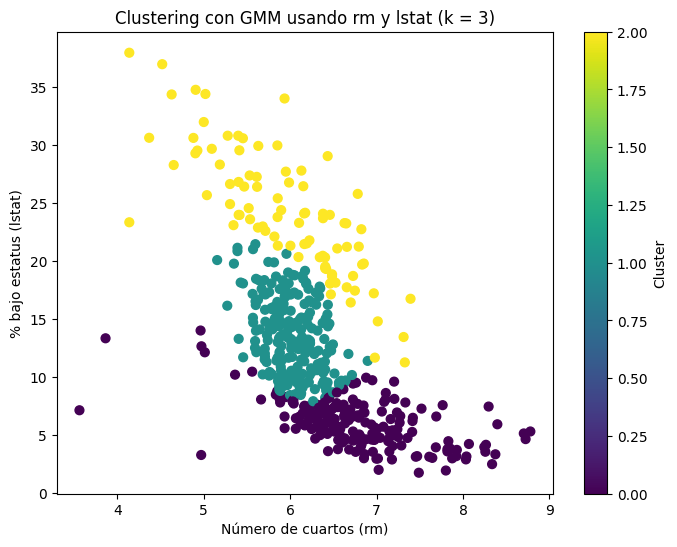

In [20]:
# Gráfico
plt.figure(figsize = (8,6))
plt.scatter(df['rm'], df['lstat'], c = df['cluster'], cmap = 'viridis', s = 40)
plt.xlabel('Número de cuartos (rm)')
plt.ylabel('% bajo estatus (lstat)')
plt.title(f'Clustering con GMM usando rm y lstat (k = {k_optimo})')
plt.colorbar(label = 'Cluster')
plt.savefig("cluster_gmm.png")
plt.show()

In [21]:
# Crear conjunto de datos
df_c0 = df[df['cluster'] == 0].reset_index()
df_c1 = df[df['cluster'] == 1].reset_index()
df_c2 = df[df['cluster'] == 2].reset_index()

[Cluster 0] Mejores parametros: {'max_depth': 3, 'n_estimators': 700}
MAE = 2.0105012635926944
RMSE = 3.0472171989913237
R2 = 0.8864846470049695


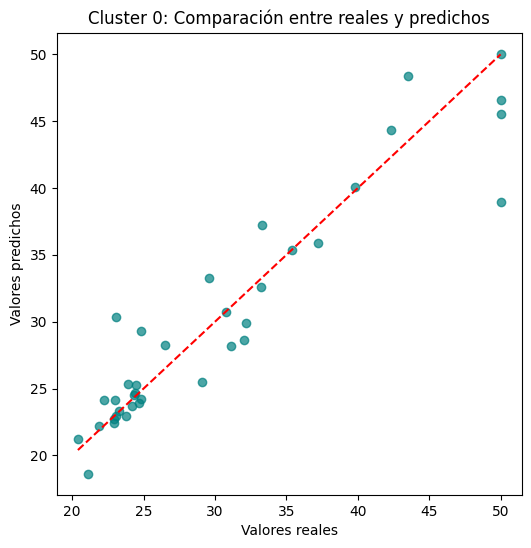

[Cluster 1] Mejores parametros: {'max_depth': 3, 'n_estimators': 400}
MAE = 1.907823485516487
RMSE = 2.746159387350702
R2 = 0.7760064480921244


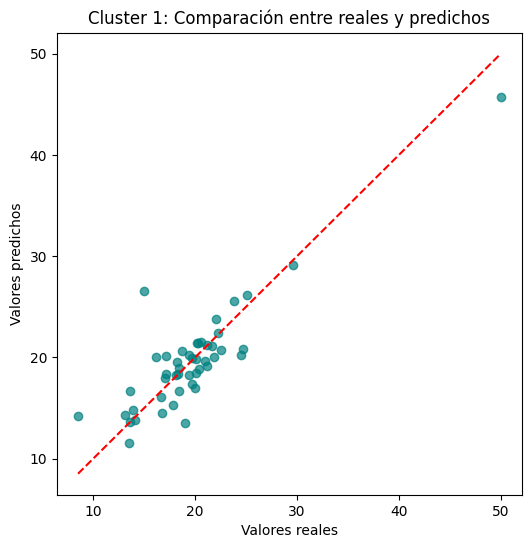

[Cluster 2] Mejores parametros: {'max_depth': 3, 'n_estimators': 700}
MAE = 1.665016598171658
RMSE = 1.9771853802523527
R2 = 0.8155645986451595


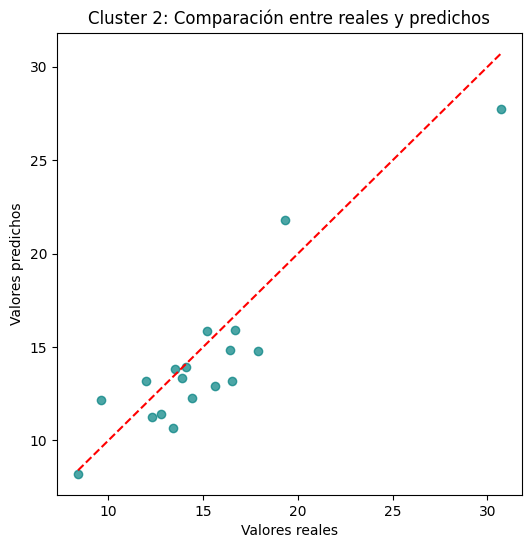


Resumen de desempeño por cluster:
   Cluster       MAE      RMSE        R2
0        0  2.010501  3.047217  0.886485
1        1  1.907823  2.746159  0.776006
2        2  1.665017  1.977185  0.815565


In [22]:
# Entrenar modelos XGBoost para cada cluster
resultados = []
for i, df_cluster in enumerate([df_c0, df_c1, df_c2]):
    resultados.append(entrenar_xgboost_cluster(df_cluster, i))

# Comparar resultados
resumen = pd.DataFrame(resultados)
print("\nResumen de desempeño por cluster:")
print(resumen)